In [1]:
import os
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import skimage
import json
from typing import List, Optional
from sklearn.metrics import confusion_matrix
import cv2
import pandas as pd
from matplotlib.lines import Line2D

import sys
sys.path.append("../")
from functions.functions_evaluation import compute_hv_in_higher_dimensions

In [2]:
plt_config = {"title": {"fontweight":"bold", "fontsize":14},
              "axis": {"fontweight":"normal", "fontsize":12},
              }

In [61]:
from skimage.measure import find_contours
from skimage.morphology import disk
from scipy.ndimage import median_filter

def mask_to_contour(mask:np.array, mode:str="outer", nclasses:int=5) -> dict:
	assert mask.ndim==2

	all_contours = {}
	for class_no in range(1, nclasses):
		mask_class = mask==class_no
		mask_class = skimage.filters.median(mask_class, disk(5))
		if mask_class.sum()>=10:
			# print("found auto contours for {}".format(class_no))
			contours = find_contours(mask_class.astype(np.float32), fully_connected='low', level=0.99)
			# note: contours is numner of contours * number of coordinates * (y, x)
			all_contours[class_no] = contours
	
	return all_contours


def calculate_dice(label, output, class_names):
    epsilon = 1e-6

    cm = confusion_matrix(label.reshape(-1), output.reshape(-1), labels=class_names)
    total_true = np.sum(cm, axis=1).astype(np.float32)
    total_pred = np.sum(cm, axis=0).astype(np.float32)
    tp = np.diag(cm)
    dice = (2 * tp) / (epsilon + total_true + total_pred)
    return 1- dice


def plot_contours(ax, all_contours, colors, linestyle="-"):
    classes_to_pick = [2, 3]
    for iclass in classes_to_pick:
        contours = all_contours.get(iclass, None)
        if contours is not None:
            for contour in contours:
                ax.plot(contour[:, 1], contour[:, 0], linewidth=1, color=colors[iclass], linestyle=linestyle)
    return ax


def visualize_pts(image:np.array, pts:list, color:tuple):
    pts = pts.reshape(-1, 3)
    imlist = []
    for (x, y, z) in pts:
        slice_no = int(round(z, 0))
        im = image[0, 0, slice_no, :, :]
        im = cv2.cvtColor(im, cv2.COLOR_GRAY2RGB)
        x, y = int(round(x, 0)), int(round(y, 0))
        im = cv2.drawMarker(im, (x, y), color, cv2.MARKER_CROSS, 6)
        imlist.append(im)
    return imlist

# # ---------- Pareto front --------------
# view_list = [(20, -70, 0),
#             (20, -20, 0),
#             (70, -60, 0)] #elevation, azimuth, and roll
# loss_functions = ["NCC Loss", "Deformation Loss", "SegSimilarity Loss"]
# colors = ["red", "green", "orange", "magenta"]
# isol_colors = dict(zip(isols, colors))
# all_colors = [isol_colors.get(idx, "blue") for idx in range(losses.shape[0])]
# # all_colors = ["blue" for idx in range(losses.shape[0])]

# fig1, ax1 = plt.subplots(1, 3, figsize=(15,5), dpi=300, subplot_kw={'projection': '3d'})
# plt.subplots_adjust(wspace=0.2, left=0.01, right=0.95)
# for i, view_angles in enumerate(view_list):
#     elev, azim, roll = view_angles
#     ax1[i].scatter(losses[:,0], losses[:,1], losses[:,2],
#             color=all_colors, s=60, zorder=4)
#     ax1[i].set_xlabel(loss_functions[0], fontsize=12, fontweight="demi")
#     ax1[i].set_ylabel(loss_functions[1], fontsize=12, fontweight="demi")
#     ax1[i].set_zlabel(loss_functions[2], fontsize=12, fontweight="demi")
#     ax1[i].invert_yaxis()
#     ax1[i].grid(visible=True, color=(0.98, 0.98, 0.98), alpha=0.5, linestyle="-", zorder=0)
#     ax1[i].view_init(elev, azim, roll)
# plt.show()

# fig1.savefig("../outputs/approximation_front.png")



## Demonstration figure

In [32]:
data_root_path = "/export/scratch2/data/grewal/Data/Projects_JPG_data/MO_DIR/LUMC_cervical_test_annotated/preprocessed111"
filepath = "../runs/final_experiments/hv_3obj_27012024_164257/fold0/run0/test/im0.npz"
data = np.load(filepath)

pts_filepath = os.path.join(data_root_path, "000_Fixed_points.json")
pts_names = json.load(open(pts_filepath, "r"))["names"]
print(pts_names)

# load all files
target_scan = data["target_image"]
source_scan = data["source_image"]
target_scan_seg = data["target_seg"]
source_scan_seg = data["source_seg"]
transformed_source_scans = data["transformed_source_images"]
transformed_source_segs = data["transformed_source_seg"]
dvfs_scan = data["dvfs"]
target_pts = data["target_pts"]
source_pts = data["source_pts"]
transformed_target_pts = data["transformed_target_pts"]
losses = np.squeeze(data["losses"])

nsols, nobj = losses.shape
nslices = dvfs_scan.shape[2]
print(target_scan_seg.shape)
print(dvfs_scan.shape)
print(losses.shape)

['int_urethral_os', 'ext_urethral_os', 'uterus_top', 'cervix_os', 'isthmus', 'iu_canal_top', 'ureteral_os_right', 'ureteral_os_left', 'int_anal_sfinct', 'coccygis', 's2s3', 's3s4', 'asbs', 'pibs_os', 'fh_right', 'fh_left', 'ac_left', 'ac_right', 'rotundum_left', 'a_uterina_right', 'a_uterina_left', 'rotundum_right']
(1, 160, 224, 224)
(27, 1, 160, 224, 224, 3)
(27, 3)


In [41]:
list(data.keys())

['target_image',
 'source_image',
 'target_seg',
 'source_seg',
 'target_pts',
 'source_pts',
 'dvfs',
 'transformed_source_images',
 'transformed_source_seg',
 'transformed_target_pts',
 'sort_indices',
 'losses',
 'tre_before',
 'tre_sols',
 'percent_foldings']

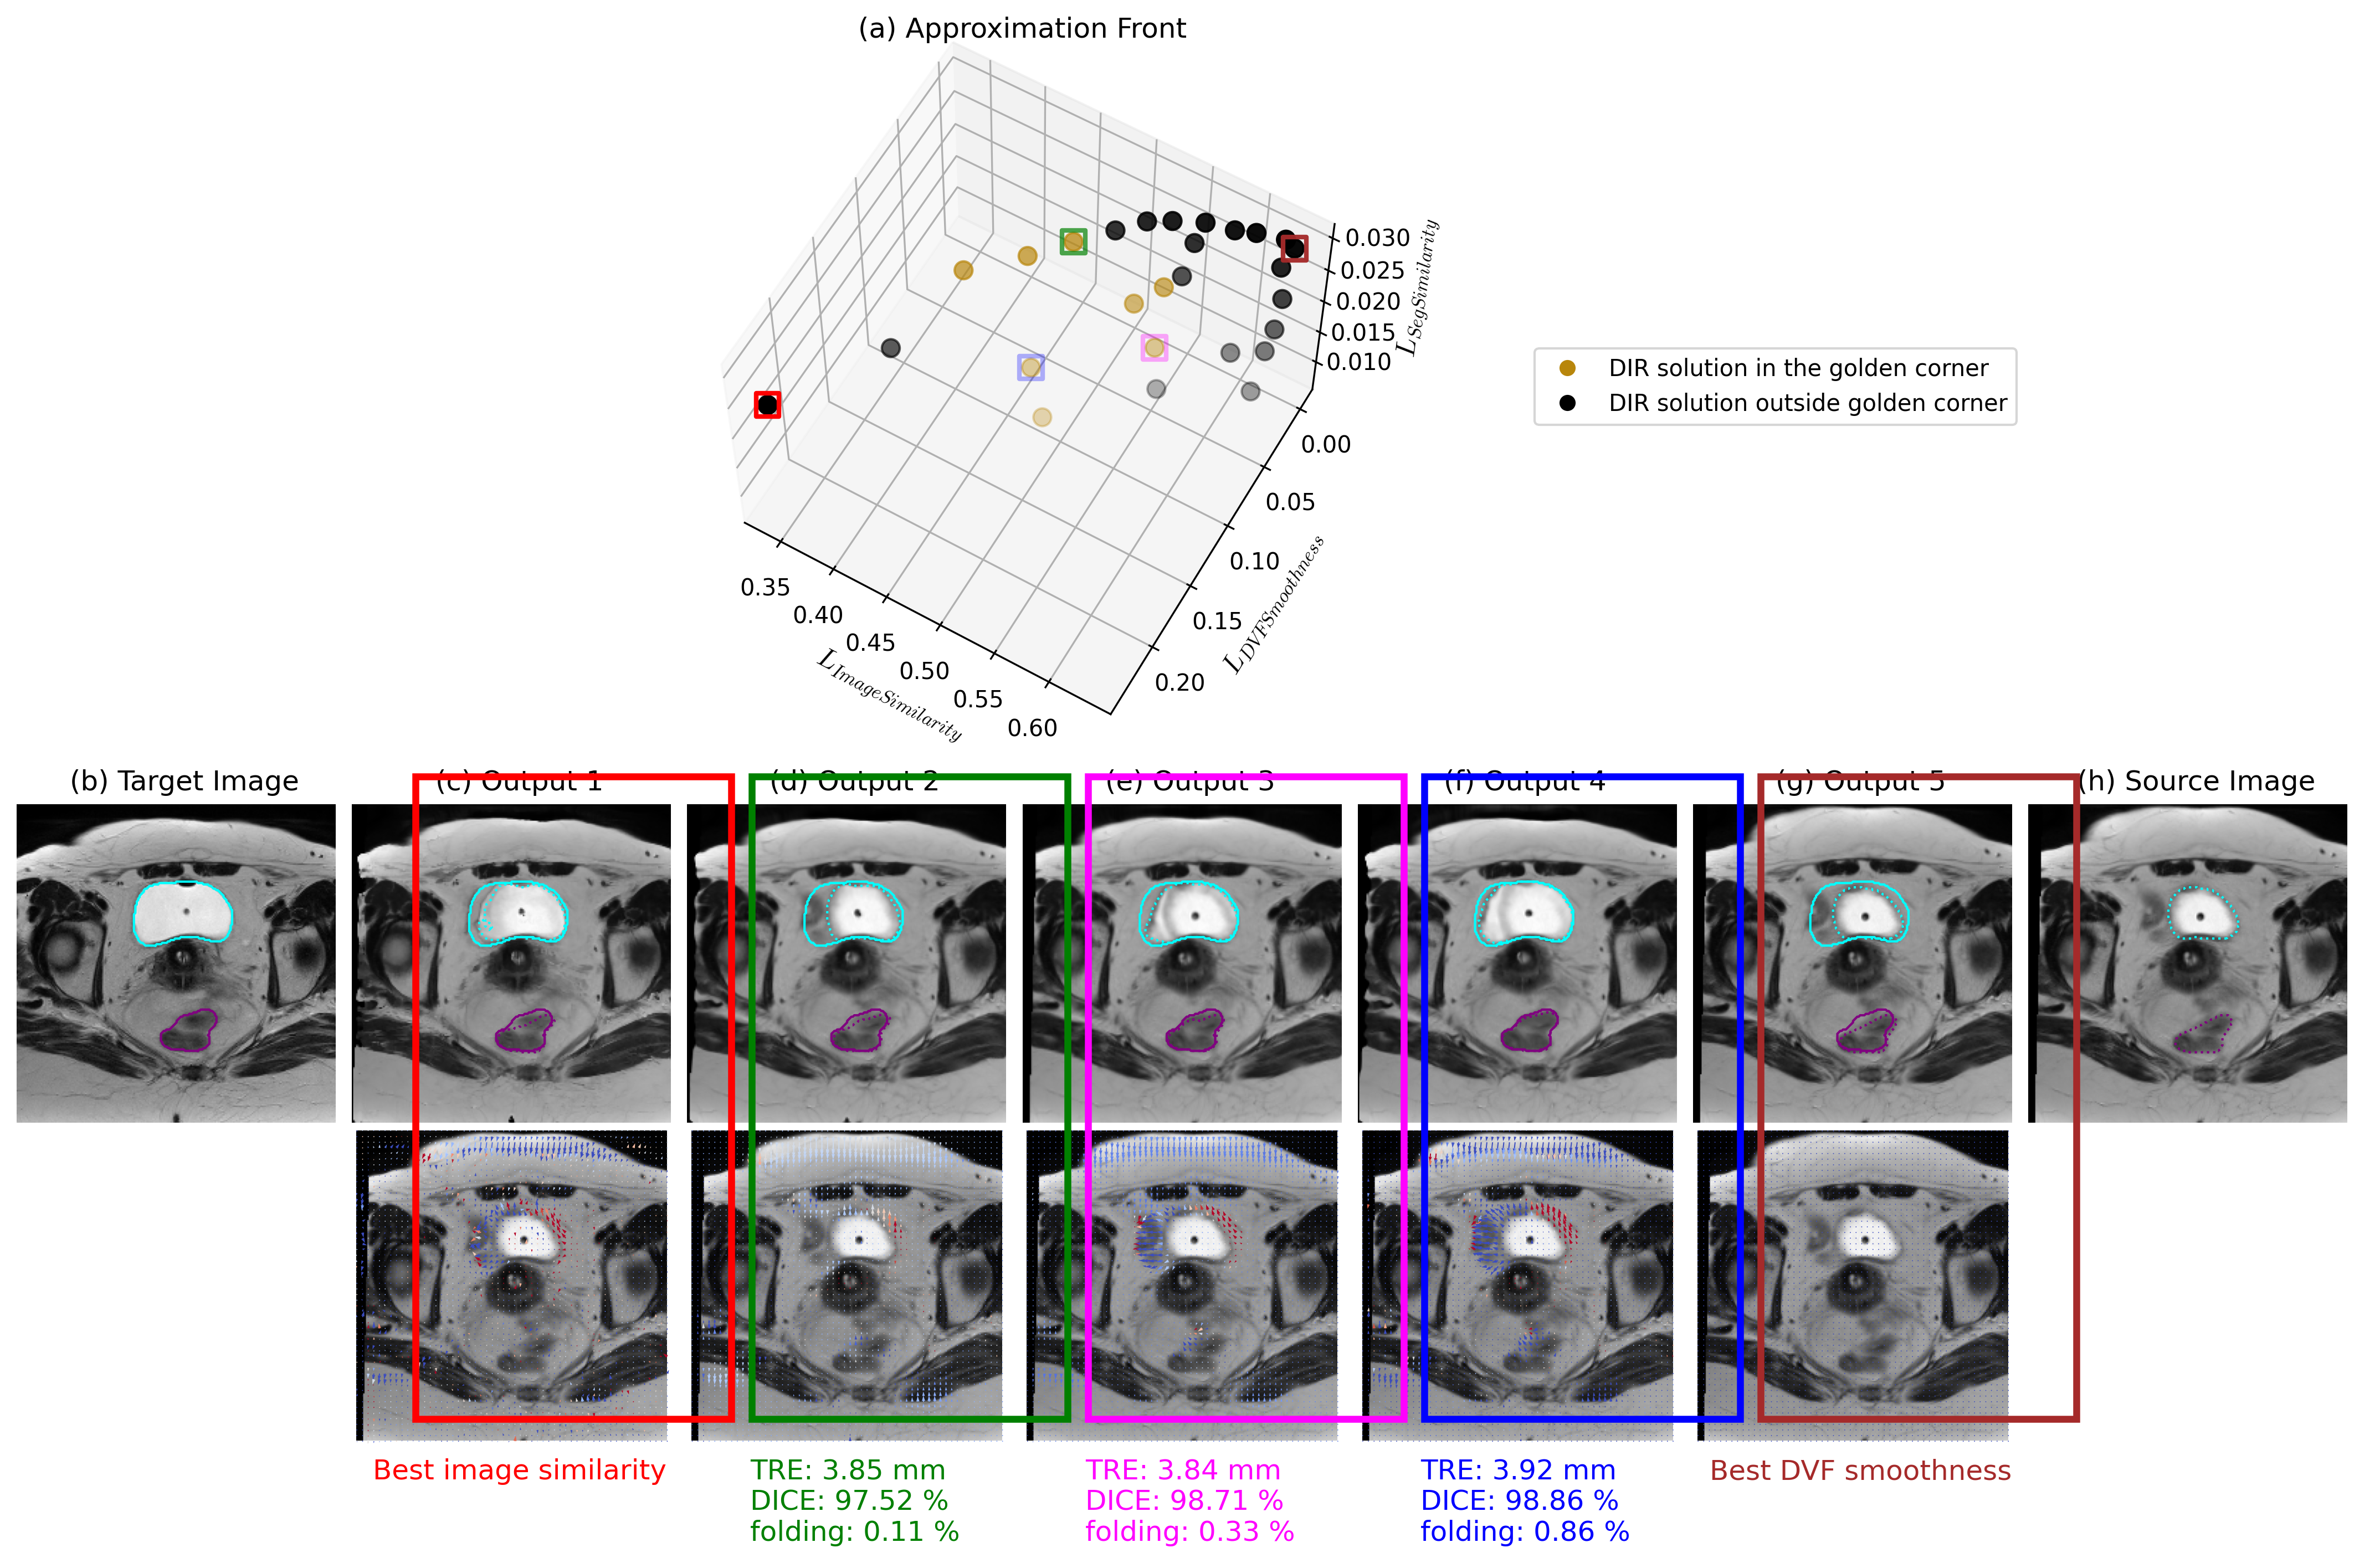

In [101]:
# plt.rcParams['text.usetex'] = False
plt.rcParams.update({'mathtext.default':  'it' })
plt.rcParams.update({'mathtext.fontset':  'cm' })

# select a slice
slice_no = 60
target_image = target_scan[0, 0, slice_no, :, :]
source_image = source_scan[0, 0, slice_no, :, :]
warped_images = transformed_source_scans[:, 0, 0, slice_no, :, :]
dvfs = dvfs_scan[:, 0, slice_no, :, :, :]

target_seg = target_scan_seg[0, slice_no, :, :]
source_seg = source_scan_seg[0, slice_no, :, :]
warped_segs = transformed_source_segs[:, 0, slice_no, :, :]

# heuristic to select isols
thresholds = [0.55, 0.1, 0.025]  # for golden corner
golden_indices = [idx for idx in range(losses.shape[0])
                  if losses[idx,0]<thresholds[0]
                        and losses[idx,1]<thresholds[1]
                        and losses[idx,2]<thresholds[2]]
isol0 = np.argsort(losses[:, 0])[0]  # best nccloss
isol5 = np.argsort(losses[:, 1])[0]  # best deformationloss
isols = [isol0, golden_indices[0], golden_indices[2], golden_indices[4], isol5]
plt_numbers = ["c", "d", "e", "f", "g"]

percent_foldings = data["percent_foldings"]
tre_sols = data["tre_sols"]
mean_tre_sols = [np.mean(tres) for tres in tre_sols]
dice = (1.0 - losses[:, 2])*100

sol_labels = ["Best image similarity\n\n", 
              f"TRE: {mean_tre_sols[isols[1]] :.2f} mm\nDICE: {dice[isols[1]] :.2f} %\nfolding: {percent_foldings[isols[1]] :.2f} %", 
              f"TRE: {mean_tre_sols[isols[2]] :.2f} mm\nDICE: {dice[isols[2]] :.2f} %\nfolding: {percent_foldings[isols[2]] :.2f} %", 
              f"TRE: {mean_tre_sols[isols[3]] :.2f} mm\nDICE: {dice[isols[3]] :.2f} %\nfolding: {percent_foldings[isols[3]] :.2f} %", 
              "Best DVF smoothness\n\n"]
isol_colors = ["red", "green", "magenta", "blue", "brown"]
all_colors = ["darkgoldenrod" if idx in golden_indices else "black" for idx in range(losses.shape[0])]
contour_colors = ["black", "red", "cyan", "purple", "yellow"]

# Set up transparency and colormap parameters
loss_functions = ['$L_{ImageSimilarity}$', "$L_{DVFSmoothness}$", "$L_{SegSimilarity}$"]
alpha = 0.5  # Transparency level for overlay
cmap = 'coolwarm'  # Colormap for highlighting differences

# Create a new figure
fig, ax = plt.subplots(4, len(isols)+2, figsize=(15, 10), dpi=300,
                       height_ratios=[1.25, 1.25, 1, 1],
                       sharey=False, sharex=True)
plt.tight_layout(rect=(0, 0.04, 0.99, 0.99))

# merge subplots for pf
gs = ax[0,0].get_gridspec()
for axes in ax[0:2, :].flatten():
    axes.remove()

# ---------- Pareto front --------------
## Plot Pareto front single view
view_angles = (60, -60, 0) #elevation, azimuth, and roll
elev, azim, roll = view_angles
axbig = fig.add_subplot(gs[0:2,2:4], projection='3d')
axbig.scatter(losses[:,0], losses[:,1], losses[:,2],
        color=all_colors, s=60, zorder=4)
axbig.scatter(losses[isols,0], losses[isols,1], losses[isols,2],
        color=isol_colors, s=100, marker='s', facecolor="none", linewidth=2, zorder=4)
axbig.set_xlabel(loss_functions[0], fontsize=12, fontweight="normal")
axbig.set_ylabel(loss_functions[1], fontsize=12, fontweight="normal")
axbig.set_zlabel(loss_functions[2], fontsize=12, fontweight="normal")
axbig.invert_yaxis()
axbig.grid(visible=True, color=(0.98, 0.98, 0.98), alpha=0.5, linestyle="-", zorder=0)
axbig.view_init(elev, azim, roll)
axbig.set_title("(a) Approximation Front", **plt_config["axis"])

custom_legend = [Line2D([0], [0], marker='o', color="w", markerfacecolor='darkgoldenrod', markersize=8,
                label='DIR solution in the golden corner'),
                Line2D([0], [0], marker='o', color="w", markerfacecolor='black', markersize=8,
                label='DIR solution outside golden corner')]
axbig.legend(handles=custom_legend, loc="center right", bbox_to_anchor=(2, 0.5))

# # padding axes
# ax[0, pf_cols-1].set_axis_off()
# ax[1, pf_cols-1].set_axis_off()

# Display the target image
ax[2, 0].imshow(target_image, cmap='gray')
target_contours = mask_to_contour(target_seg)
ax[2, 0] = plot_contours(ax[2, 0], target_contours, contour_colors, linestyle="-")
ax[2, 0].set_title('(b) Target Image', **plt_config["axis"])
ax[2, 0].set_axis_off()


# Display the source image
ax[2, -1].imshow(source_image, cmap='gray')
all_contours = mask_to_contour(source_seg)
ax[2, -1] = plot_contours(ax[2, -1], all_contours, contour_colors, linestyle="dotted")
ax[2, -1].set_title('(h) Source Image', **plt_config["axis"])
ax[2, -1].set_axis_off()


ax[3, 0].set_axis_off()
ax[3, -1].set_axis_off()

# settings for dvf display
shape = target_image.shape
nsteps = 56
step_size = shape[0]//nsteps
x, y = np.meshgrid(np.linspace(0, shape[1], nsteps),
                    np.linspace(0, shape[0], nsteps))

for idx, isol in enumerate(isols):
    warped_image = warped_images[isol, :, :]
    # Display the warped image
    ax[2, 1+idx].imshow(warped_image, cmap='gray')
    # dispaly seg contours
    all_contours = mask_to_contour(warped_segs[isol, :, :])
    ax[2, 1+idx] = plot_contours(ax[2, 1+idx], target_contours, contour_colors, linestyle="-")
    ax[2, 1+idx] = plot_contours(ax[2, 1+idx], all_contours, contour_colors, linestyle="dotted")

    plt_number = plt_numbers[idx]
    ax[2, 1+idx].set_title(f"({plt_number}) Output {idx+1}", **plt_config["axis"])
    ax[2, 1+idx].set_axis_off()

    # display DVF
    ax[3, 1+idx].imshow(source_image, cmap='gray')
    dvf = (-1) * dvfs[isol, :, :, :]
    u = dvf[::step_size, ::step_size, 0]
    v = dvf[::step_size, ::step_size, 1]
    w = dvf[::step_size, ::step_size, 2]
    dvf_colors = matplotlib.colormaps['coolwarm'](w.reshape(-1))
    ax[3, 1+idx].quiver(x, y, u, v, width=0.8, scale=1, units='xy', angles='xy', color=dvf_colors)
    ax[3, 1+idx].set_axis_off()
#     ax[3, 1+idx].set_title(f"{sol_labels[idx]}", **plt_config["axis"], y=-0.1, color=colors[idx], multialignment='left')
    ax[3, 1+idx].set_title(f"{sol_labels[idx]}", y=-0.3, color=isol_colors[idx], multialignment='left')
    ax[3, 1+idx].set_axis_off()

# draw frames
start = 750
w = 570
pad = 37
rects = [plt.Rectangle((start, 260), w, 1160, facecolor="none", linewidth=3,
                        edgecolor=isol_colors[0], zorder=2),
        plt.Rectangle((start + w + pad, 260), w, 1160, facecolor="none", linewidth=3,
                        edgecolor=isol_colors[1], zorder=2),
        plt.Rectangle((start + 2*w + 2*pad, 260), w, 1160, facecolor="none", linewidth=3,
                        edgecolor=isol_colors[2], zorder=2),
        plt.Rectangle((start + 3*w + 3*pad, 260), w, 1160, facecolor="none", linewidth=3,
                        edgecolor=isol_colors[3], zorder=2),
        plt.Rectangle((start + 4*w + 4*pad, 260), w, 1160, facecolor="none", linewidth=3,
                        edgecolor=isol_colors[4], zorder=2),
            ]
fig.patches.extend(rects)

# plt.text(2570, 1600, "The golden corner is defined by $L_{ImageSimilarity}$ < 0.55, \
#            $L_{DVFSmoothness}$ < 0.1, $L_{SegSimilarity}$ < 0.025. Note that the thresholds for defining the golden corner are arbitrarily chosen.", \
#             multialignment="center")
plt.subplots_adjust(wspace=0, hspace=0.01)
fig.savefig("../outputs/demonstrate.png")
plt.show()

In [ ]:
# plt.rcParams['text.usetex'] = False
plt.rcParams.update({'mathtext.default':  'it' })
plt.rcParams.update({'mathtext.fontset':  'cm' })

# select a slice
slice_no = 60
target_image = target_scan[0, 0, slice_no, :, :]
source_image = source_scan[0, 0, slice_no, :, :]
warped_images = transformed_source_scans[:, 0, 0, slice_no, :, :]
dvfs = dvfs_scan[:, 0, slice_no, :, :, :]

target_seg = target_scan_seg[0, slice_no, :, :]
source_seg = source_scan_seg[0, slice_no, :, :]
warped_segs = transformed_source_segs[:, 0, slice_no, :, :]

# heuristic to select isols
sort_indices = np.argsort(losses[:, 0])
isol0 = np.argsort(losses[:, 1])[0]  #best deformationloss
isol1 = np.argsort(losses[:, 2])[1]  #best segloss
isol2 = np.argsort(losses[:, 0])[5]  #medium segloss
isol3 = np.argsort(losses[:, 0])[0]  #best nccloss
isols = [isol0, isol1, isol2, isol3]
plt_numbers = ["c", "d", "e", "f"]
sol_labels = ["Best DVF smoothness", "Best seg similarity", "Intermediate", "Best image similarity"]

# Set up transparency and colormap parameters
alpha = 0.5  # Transparency level for overlay
cmap = 'coolwarm'  # Colormap for highlighting differences

# Create a new figure
pf_cols = 2
fig, ax = plt.subplots(2, len(isols)+2+pf_cols, figsize=(15, 4), dpi=300, sharey=False, sharex=True)

# merge subplots for pf
gs = ax[0,0].get_gridspec()
for axes in ax[:, :pf_cols].flatten():
    axes.remove()
axbig = fig.add_subplot(gs[:,:pf_cols], projection='3d')

## Plot Pareto front single view
# ---------- Pareto front --------------
view_angles = (60, -30, 0) #elevation, azimuth, and roll
loss_functions = ['$L_{ImageSimilarity}$', "$L_{DVFSmoothness}$", "$L_{SegSimilarity}$"]
colors = ["red", "green", "orange", "magenta"]
contour_colors = ["black", "red", "cyan", "purple", "yellow"]
isol_colors = dict(zip(isols, colors))
all_colors = [isol_colors.get(idx, "blue") for idx in range(losses.shape[0])]

elev, azim, roll = view_angles
axbig.scatter(losses[:,0], losses[:,1], losses[:,2],
        color=all_colors, s=60, zorder=4)
axbig.set_xlabel(loss_functions[0], fontsize=12, fontweight="normal")
axbig.set_ylabel(loss_functions[1], fontsize=12, fontweight="normal")
axbig.set_zlabel(loss_functions[2], fontsize=12, fontweight="normal")
axbig.invert_yaxis()
axbig.grid(visible=True, color=(0.98, 0.98, 0.98), alpha=0.5, linestyle="-", zorder=0)
axbig.view_init(elev, azim, roll)
axbig.set_title("(a) Approximation Front", **plt_config["axis"])

# padding axes
ax[0, pf_cols-1].set_axis_off()
ax[1, pf_cols-1].set_axis_off()

# Display the target image
ax[0, pf_cols+0].imshow(target_image, cmap='gray')
target_contours = mask_to_contour(target_seg)
ax[0, pf_cols+0] = plot_contours(ax[0, pf_cols+0], target_contours, contour_colors, linestyle="-")
ax[0, pf_cols+0].set_title('(b) Target Image', **plt_config["axis"])
ax[0, pf_cols+0].set_axis_off()


# Display the source image
ax[0, -1].imshow(source_image, cmap='gray')
all_contours = mask_to_contour(source_seg)
ax[0, -1] = plot_contours(ax[0, -1], all_contours, contour_colors, linestyle="dotted")
ax[0, -1].set_title('(g) Source Image', **plt_config["axis"])
ax[0, -1].set_axis_off()


ax[1, pf_cols+0].set_axis_off()
# ax[2, 0].set_axis_off()
ax[1, -1].set_axis_off()
# ax[2, -1].set_axis_off()

# settings for dvf display
shape = target_image.shape
nsteps = 56
step_size = shape[0]//nsteps
x, y = np.meshgrid(np.linspace(0, shape[1], nsteps),
                    np.linspace(0, shape[0], nsteps))

for idx, isol in enumerate(isols):
    warped_image = warped_images[isol, :, :]
    # Display the warped image
    ax[0, pf_cols+1+idx].imshow(warped_image, cmap='gray')
    # dispaly seg contours
    all_contours = mask_to_contour(warped_segs[isol, :, :])
    ax[0, pf_cols+1+idx] = plot_contours(ax[0, pf_cols+1+idx], target_contours, contour_colors, linestyle="-")
    ax[0, pf_cols+1+idx] = plot_contours(ax[0, pf_cols+1+idx], all_contours, contour_colors, linestyle="dotted")

    plt_number = plt_numbers[idx]
    ax[0, pf_cols+1+idx].set_title(f"({plt_number}) Output {idx+1}", **plt_config["axis"])
    ax[0, pf_cols+1+idx].set_axis_off()

    # # Display the difference image
    # difference_image = target_image - warped_image
    # ax[1, 1+idx].imshow(difference_image, cmap=cmap)
    # ax[1, 1+idx].set_axis_off()

    # # Display the colorbar to indicate the colormap scale
    # cbar = plt.colorbar(location="bottom", shrink=0.6)
    # cbar.set_label('Difference Magnitude')

    # display DVF
    ax[1, pf_cols+1+idx].imshow(source_image, cmap='gray')
    dvf = (-1) * dvfs[isol, :, :, :]
    u = dvf[::step_size, ::step_size, 0]
    v = dvf[::step_size, ::step_size, 1]
    w = dvf[::step_size, ::step_size, 2]
    dvf_colors = matplotlib.colormaps['coolwarm'](w.reshape(-1))
    ax[1, pf_cols+1+idx].quiver(x, y, u, v, width=0.8, scale=1, units='xy', angles='xy', color=dvf_colors)
    ax[1, pf_cols+1+idx].set_axis_off()
    ax[1, pf_cols+1+idx].set_title(f"{sol_labels[idx]}", **plt_config["axis"], y=-0.1, color=colors[idx])
    ax[1, pf_cols+1+idx].set_axis_off()

# draw frames
rects = [plt.Rectangle((1700, 87), 510, 1046, facecolor="none", linewidth=3,
                        edgecolor=colors[0], zorder=2),
        plt.Rectangle((2257, 87), 510, 1046, facecolor="none", linewidth=3,
                        edgecolor=colors[1], zorder=2),
        plt.Rectangle((2814, 87), 510, 1046, facecolor="none", linewidth=3,
                        edgecolor=colors[2], zorder=2),
        plt.Rectangle((3371, 87), 510, 1046, facecolor="none", linewidth=3,
                        edgecolor=colors[3], zorder=2),
            ]
fig.patches.extend(rects)
plt.subplots_adjust(wspace=0.005, hspace=0.01, left=0.005, right=0.995, bottom=0.05, top=0.94)
# fig.savefig("../outputs/demonstrate.png")
plt.show()

## MO Decision Making

In [ ]:
data_root_path = "/export/scratch2/data/grewal/Data/Projects_JPG_data/MO_DIR/LUMC_cervical_test_annotated/preprocessed111"
runs_root_path = "../runs/isotropic/"
# experiment_name = "ls_3obj_21102023_153652"
experiment_name = "hv_3obj_ref111_nsol25_plain_26102023_120834"
scan_no = 1

filepath = os.path.join(runs_root_path, experiment_name, "fold0", "run0", "test", f"im{scan_no}.npz")
data = np.load(filepath)
pts_filepath = os.path.join(data_root_path, "{0:03d}_Fixed_points.json".format(scan_no))
pts_names = json.load(open(pts_filepath, "r"))["names"]

# load all files
# target_scan = data["target_image"]
# source_scan = data["source_image"]
# target_scan_seg = data["target_seg"]
# source_scan_seg = data["source_seg"]
# transformed_source_scans = data["transformed_source_images"]
# transformed_source_segs = data["transformed_source_seg"]
# dvfs_scan = data["dvfs"]
# target_pts = data["target_pts"]
# source_pts = data["source_pts"]
# transformed_target_pts = data["transformed_target_pts"]
losses = np.squeeze(data["losses"])
tre_sols = data["tre_sols"]
tre_before = data["tre_before"]
percent_foldings = data["percent_foldings"]

nsols, nobj = losses.shape
# nslices = dvfs_scan.shape[2]
npoints = len(pts_names)
class_names = [1, 2, 3, 4]
class_labels = ["Bowel", "Bladder", "Rectum", "Sigmoid"]


# # ----------- calculate metrics ---------------------------
# # ---------- percent folding -------------------
# # smmoth_dvfs = [postprocess_dvf(dvf[0]) for dvf in dvfs_scan]
# percent_foldings = [calculate_percent_folding(dvf[0]) for dvf in dvfs_scan]
# # print("Percent folding: ", percent_foldings)

# # ----------- TRE ------------------------------
# tre_before = calculate_tre(target_pts, source_pts)
# tre_sols = [calculate_tre(transformed_target_pts[idx, ...], source_pts) for idx in range(nsols)]
mean_tre_sols = [np.mean(tre) for tre in tre_sols]
print("TRE before: ", tre_before.mean())
print("TRE Afters: ", np.max(mean_tre_sols), np.min(mean_tre_sols))

# # --------- DICE score -----------------
# dice_before = calculate_dice(target_scan_seg, source_scan_seg, class_names)
# print("DICE before: ", dice_before)

In [ ]:
plt.rcParams.update({'mathtext.default':  'it' })
plt.rcParams.update({'mathtext.fontset':  'cm' })
colors = matplotlib.colormaps['coolwarm'](np.linspace(0, 1, nsols))

sort_metrics_label = ["TRE", "Dice loss", "Percent folding"]
sort_metrics = []
sort_indices_list = []
# sort according to mean TRE
mean_tre_sols = [np.mean(tre) for tre in tre_sols]
sort_indices = np.argsort(mean_tre_sols)
print(sort_indices)
sort_indices_list.append(sort_indices)
sort_metrics.append(mean_tre_sols)

# sort according to dice bowel
dice = losses[:,2]
sort_indices = np.argsort(dice)
sort_indices_list.append(sort_indices)
sort_metrics.append(dice)

# sort according to percent folding
sort_indices = np.argsort(percent_foldings)
sort_indices_list.append(sort_indices)
sort_metrics.append(percent_foldings)

# ---------- Pareto front --------------
# view_angle = (30, -60, 0) #elevation, azimuth, and roll
view_angle = (30, -60, 0)
loss_functions = ['$L_{ImageSimilarity}$', "$L_{DVFSmmothness}$", "$L_{SegSimilarity}$"]

fig, ax = plt.subplots(1, 3, figsize=(18,5), dpi=300, subplot_kw={'projection': '3d'})
plt.subplots_adjust(left=0.05, bottom=0.1, right=0.9, top=0.95, wspace=0.02)
elev, azim, roll = view_angle
for i in range(len(sort_metrics_label)):
    losses_sorted = losses[sort_indices_list[i], :]
    ax[i].scatter(losses_sorted[:,0], losses_sorted[:,1], losses_sorted[:,2],
        color=colors, s=60, alpha=1, zorder=4)
    ax[i].set_xlabel(loss_functions[0], fontsize=12, fontweight="demi")
    ax[i].set_ylabel(loss_functions[1], fontsize=12, fontweight="demi")
    ax[i].set_zlabel(loss_functions[2], fontsize=12, fontweight="demi")
    ax[i].invert_yaxis()
    ax[i].grid(visible=True, color=(0.98, 0.98, 0.98), linestyle="-", zorder=0)
    ax[i].view_init(elev, azim, roll)

    # colorbar
    cmap = matplotlib.colormaps['coolwarm']
    norm = matplotlib.colors.BoundaryNorm(np.round(np.sort(sort_metrics[i]), 2), cmap.N)
    fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap),
        ax=ax[i], orientation='horizontal', label=sort_metrics_label[i], shrink=0.6, anchor=(0.5, 0),)

# cmap_dice = matplotlib.colors.LinearSegmentedColormap.from_list(
#     'Custom cmap', cmap, cmap.N)
# dice_bowel = [100-item[0] for item in dice_sols]
# norm = matplotlib.colors.BoundaryNorm(np.sort(dice_bowel), cmap_dice.N)
# fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap_dice),
#              ax=ax1, orientation='vertical', label='DICE', shrink=0.9, anchor=(1.2, 0),)

plt.show()
# fig.savefig("../outputs/mo_decision_making_scan1.png")

In [ ]:
plt.scatter([1], [tre_before.mean()], color='k')
plt.scatter(np.ones(nsols), mean_tre_sols, color='b')

## make pareto front comparison plot with losses

In [4]:
root_path = "../runs/"
experiment_names = ["Grid search", "MO DIR"]
experiment_paths = ["final_experiments/ls_3obj_27012024_163005",
                    "final_experiments/hv_3obj_27012024_164257"]
ref_point = (1, 1, 1)

# experiment_names = ["No Guidance", "Guidance"]
# experiment_paths = ["final_experiments/hv_3obj_no_guidance_27012024_164218",
#                     "final_experiments/hv_3obj_27012024_164257"]
# ref_point = (1, 1, 1)

# experiment_names = ["No parameter sharing", "Parameter sharing"]
# experiment_paths = ["final_experiments/hv_2obj_deep_28012024_171135",
#                     "final_experiments/hv_2obj_khead_28012024_171215"]
# ref_point = (1, 1)
markers = ['.', 'v', '*']
scan_numbers = list(range(10))
nfolds = 5


descriptives_info = []
losses_info = []

for i, experiment_name in enumerate(experiment_names):
    for i_fold in range(nfolds):
        for scan_number in scan_numbers:
            experiment_path = experiment_paths[i]
            filepath = os.path.join(root_path, experiment_path, f"fold{i_fold}", "run0", "test", f"im{scan_number}.npz")
            data = np.load(filepath)

            tre_before = np.mean(data["tre_before"])
            tre = data["tre_sols"] #nsols * npoints
            mean_tre = np.mean(tre, axis=1)
            min_mean_tre = np.min(mean_tre)
            min_mean_tre_idx = np.argmin(mean_tre)
            percent_foldings = data["percent_foldings"]
            percent_folding_min_tre = percent_foldings[min_mean_tre_idx]

            losses = np.squeeze(data["losses"]) #nsols * nobj
            hv = compute_hv_in_higher_dimensions(losses.T, ref_point)

            dice = (1 - losses[:, 2])*100
            max_dice = np.max(dice)
            max_dice_idx = np.argmax(dice)
            percent_folding_max_dice = percent_foldings[max_dice_idx]

            descriptives_info.append({
                "experiment_name": experiment_name,
                "fold": i_fold,
                "scan": scan_number,
                "tre_before": tre_before,
                "min_tre": min_mean_tre,
                "min_tre_sol": min_mean_tre_idx,
                "folding_min_tre": percent_folding_min_tre,
                "hv": hv,
                "max_dice": max_dice,
                "folding_max_dice": percent_folding_max_dice
            })
            losses_info.append({
                "experiment_name": experiment_name,
                "fold": i_fold,
                "scan": scan_number,
                "losses": losses,
                "tre_before": tre_before,
                "tre": mean_tre,
                "folding": percent_foldings
            })

print(list(data.keys()))    
descriptives_df = pd.DataFrame(descriptives_info)

['target_pts', 'source_pts', 'transformed_target_pts', 'losses', 'tre_before', 'tre_sols', 'percent_foldings']


### Descriptives

In [5]:
new_df = descriptives_df[["experiment_name", "scan", "max_dice", "folding_max_dice"]].groupby(["experiment_name", "scan"]).agg(["mean", "std"])
new_df.iloc[0:20]

max_dice           folding_max_dice          
                           mean       std             mean       std
experiment_name scan                                                
Grid search     0     99.298599  0.033313         0.943236  0.155173
                1     95.416031  0.309813         1.396167  0.242333
                2     99.014053  0.054281         1.127484  0.149763
                3     98.468994  0.129789         0.921991  0.109540
                4     98.162621  0.081599         0.808985  0.170731
                5     98.782974  0.044690         1.142048  0.117085
                6     99.048103  0.073204         0.891707  0.081130
                7     99.067276  0.055834         0.766490  0.076314
                8     97.955276  0.125775         1.190830  0.085801
                9     97.428345  0.141757         1.065006  0.261721
MO DIR          0     99.278358  0.058372         0.772155  0.218464
                1     95.657326  0.262246         1.382309  0.284950
                2     98.990028  0.099818         0.930164  0.170724
                3     98.526596  0.133243         0.867603  0.279800
                4     98.236839  0.091881         0.657814  0.073412
                5     98.730446  0.131083         0.995444  0.371000
                6     99.007751  0.108651         0.957186  0.489677
                7     99.069176  0.074867         0.642743  0.110364
                8     98.007187  0.107171         1.093664  0.415849
                9     97.482903  0.115256         1.015144  0.263516

#### Plotting

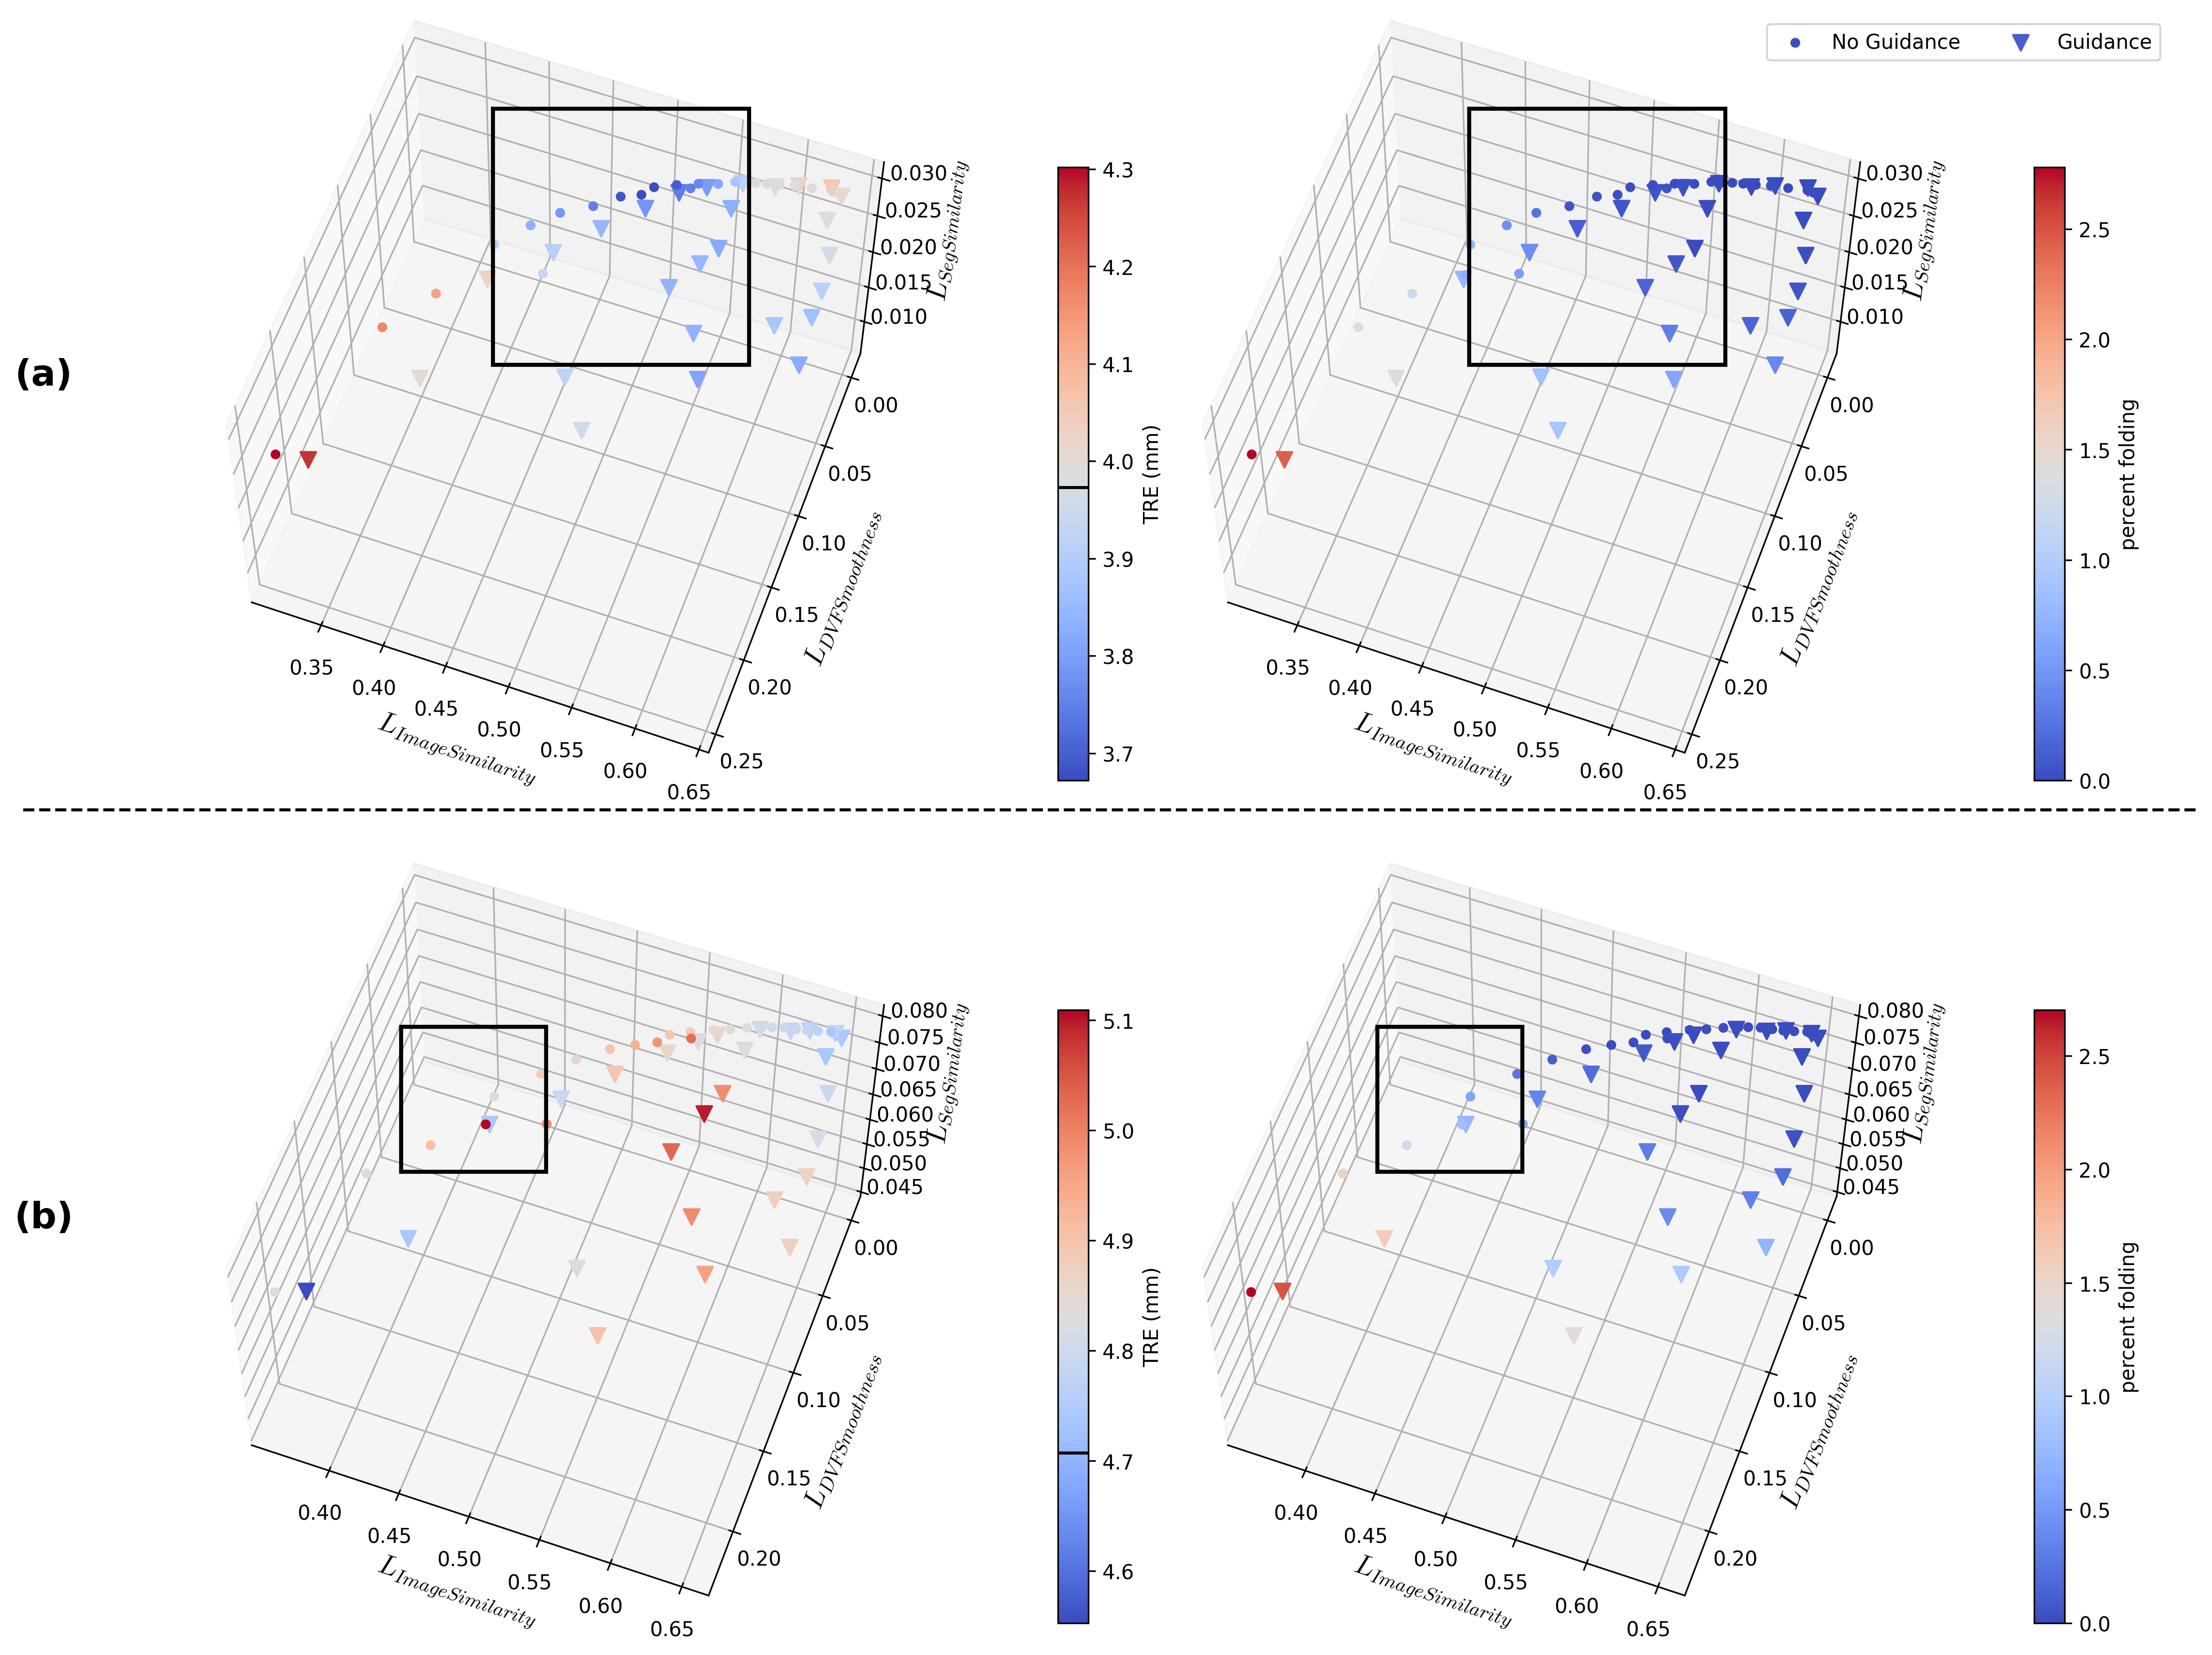

In [17]:
plt.rcParams.update({'mathtext.default':  'it' })
plt.rcParams.update({'mathtext.fontset':  'cm' })

plt_config = {"title": {"fontweight":"bold", "fontsize":16},
              "axis": {"fontweight":"demi", "fontsize":14},
              }

# plotting
fold_no = 0
scans = [0, 1]
nsols, nobj = losses_info[0]["losses"].shape
cmap = matplotlib.colormaps['coolwarm']

view_list = [(30, -60, 0),
            (30, -30, 0),
            (60, -70, 0)] #elevation, azimuth, and roll
elev, azim, roll = view_list[2]
axis_prop = None
loss_functions = ['$L_{ImageSimilarity}$', "$L_{DVFSmoothness}$", "$L_{SegSimilarity}$"]

fig, ax = plt.subplots(len(scans), 2, figsize=(15, 12), dpi=300, subplot_kw={'projection': '3d'})
# plt.subplots_adjust(left=0.1, right=0.95, bottom=0.02, top=0.98)
plt.tight_layout(rect=(0, 0.02, 0.98, 0.98))
plt.subplots_adjust(hspace=0.1)
for idx, scan_no in enumerate(scans):
    losses_info_scan = list(filter(lambda x: x["scan"]==scan_no and x["fold"]==fold_no, losses_info))
    # tre before
    tre_before = losses_info_scan[0]["tre_before"]
    # decide bounds for tre
    all_tre_mins = [np.min(item["tre"]) for item in losses_info_scan]
    all_tre_maxs = [np.max(item["tre"]) for item in losses_info_scan]
    min_tre = np.min(all_tre_mins)
    max_tre = np.max(all_tre_maxs)
    tre_bounds = [min_tre, max_tre]

    #decide bounds for folding
    all_folding_mins = [np.min(item["folding"]) for item in losses_info_scan]
    all_folding_maxs = [np.max(item["folding"]) for item in losses_info_scan]
    min_folding = np.min(all_folding_mins)
    max_folding = np.max(all_folding_maxs)
    folding_bounds = [min_folding, max_folding]

    normalizer_tre = matplotlib.colors.Normalize(*tre_bounds)
    scalar_mapping_tre = matplotlib.cm.ScalarMappable(norm=normalizer_tre, cmap=cmap)
    normalizer_folding = matplotlib.colors.Normalize(*folding_bounds)
    scalar_mapping_folding = matplotlib.cm.ScalarMappable(norm=normalizer_folding, cmap=cmap)
    for experiment_no, experiment_name in enumerate(experiment_names):
        loss_info = list(filter(lambda x: x["experiment_name"]==experiment_name, losses_info_scan))[0]
        losses = loss_info["losses"]
        mean_tres = loss_info["tre"]
        percent_foldings = loss_info["folding"]
        
        ax[idx, 0].scatter(losses[:,0], losses[:,1], losses[:,2],
                    c=mean_tres, cmap=cmap, norm=normalizer_tre,
                    label=experiment_name, marker=markers[experiment_no], s=60, alpha=1)
        ax[idx, 1].scatter(losses[:,0], losses[:,1], losses[:,2],
                    c=percent_foldings, cmap=cmap, norm=normalizer_folding,
                    label=experiment_name, marker=markers[experiment_no], s=60, alpha=1)
    # ax[idx, 0].legend(loc="upper center", ncols=len(loss_info), bbox_to_anchor=(-0.5, 0.15, 2, 1))
    ax[idx, 0].set_xlabel(loss_functions[0], **plt_config["axis"])
    ax[idx, 0].set_ylabel(loss_functions[1], **plt_config["axis"])
    ax[idx, 0].set_zlabel(loss_functions[2], **plt_config["axis"])
    ax[idx, 0].invert_yaxis()
    ax[idx, 0].view_init(elev, azim, roll)
    # ax[idx, 0].legend(loc="lower right", bbox_to_anchor=(1, 0, 0.2, 0.2))
    # colorbar
    cx = fig.colorbar(scalar_mapping_tre, ax=ax[idx, 0], orientation='vertical', \
                 shrink=0.8, anchor=(0.5, 0), label="TRE (mm)")
    cx.ax.plot([0, 1], [tre_before, tre_before], 'k')

    ax[idx, 1].set_xlabel(loss_functions[0], **plt_config["axis"])
    ax[idx, 1].set_ylabel(loss_functions[1], **plt_config["axis"])
    ax[idx, 1].set_zlabel(loss_functions[2], **plt_config["axis"])
    ax[idx, 1].invert_yaxis()
    ax[idx, 1].view_init(elev, azim, roll)
    if idx==0:
        ax[idx, 1].legend(loc="upper left", ncol=2, bbox_to_anchor=(0.8, 0.8, 0.5, 0.2))
    # colorbar
    fig.colorbar(scalar_mapping_folding, ax=ax[idx, 1], orientation='vertical', \
                 shrink=0.8, anchor=(0.5, 0), label='percent folding')

title_a = ax[0, 0].set_title("(a)", y=0.5, loc='left', fontweight="bold", fontsize=18)
title_a.set_position([-0.2, 0.5])
title_b = ax[1, 0].set_title("(b)", y=0.5, loc='left', fontweight="bold", fontsize=18)
title_b.set_position([-0.2, 0.5])

fig.add_artist(matplotlib.lines.Line2D([0, 1], [0.5, 0.5], color='k', linestyle="--"))

# draw frames
rects = [plt.Rectangle((1020, 2670), 530, 530, facecolor="none", linewidth=2,
                        edgecolor='black', zorder=2),
        plt.Rectangle((3040, 2670), 530, 530, facecolor="none", linewidth=2,
                        edgecolor='black', zorder=2),
        plt.Rectangle((830, 1000), 300, 300, facecolor="none", linewidth=2,
                        edgecolor='black', zorder=2),
        plt.Rectangle((2850, 1000), 300, 300, facecolor="none", linewidth=2,
                        edgecolor='black', zorder=2),
            ]
fig.patches.extend(rects)

plt.show()
# fig.savefig(f"../outputs/ls_vs_hv.png")


## Effect of additional guidance

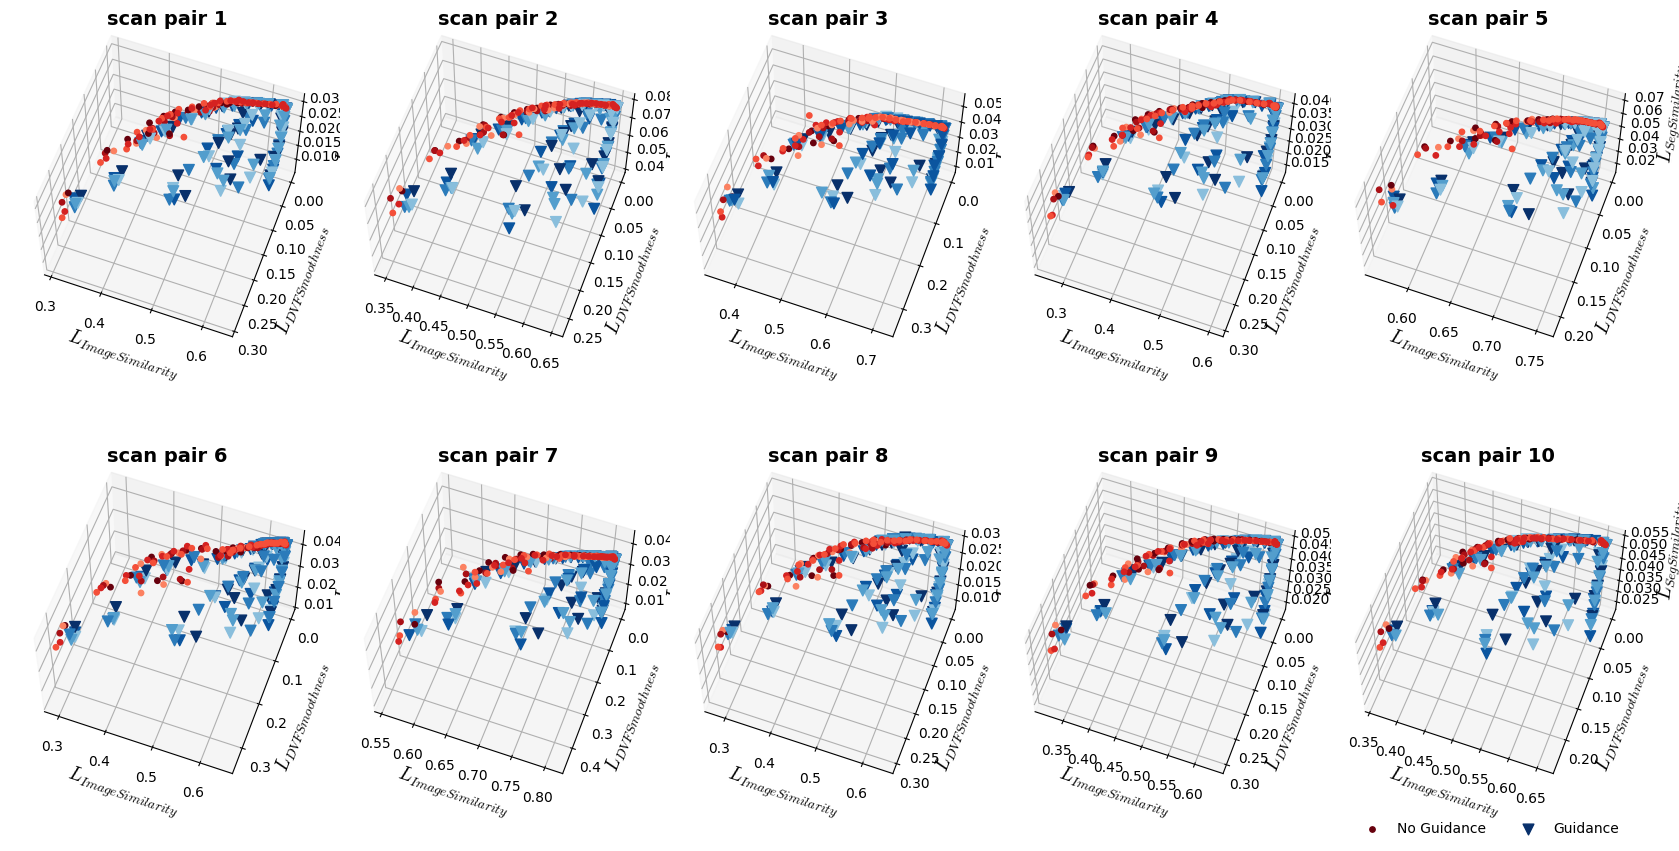

In [32]:
plt.rcParams.update({'mathtext.default':  'it' })
plt.rcParams.update({'mathtext.fontset':  'cm' })

plt_config = {"title": {"fontweight":"bold", "fontsize":16},
              "axis": {"fontweight":"demi", "fontsize":14},
              }

# plotting
scans = list(range(10))
nsols, nobj = losses_info[0]["losses"].shape
cmaps = [plt.cm.get_cmap('Reds')(np.linspace(0, 1, 8))[::-1], 
         plt.cm.get_cmap('Blues')(np.linspace(0, 1, 8))[::-1]]

view_list = [(30, -60, 0),
            (30, -30, 0),
            (60, -70, 0)] #elevation, azimuth, and roll
elev, azim, roll = view_list[2]
axis_prop = None
loss_functions = ['$L_{ImageSimilarity}$', "$L_{DVFSmoothness}$", "$L_{SegSimilarity}$"]

fig, ax = plt.subplots(2, 5, figsize=(17, 9), dpi=100, subplot_kw={'projection': '3d'})
# plt.subplots_adjust(left=0.1, right=0.95, bottom=0.02, top=0.98)
plt.tight_layout(rect=(0, 0.02, 0.98, 0.98))
plt.subplots_adjust(hspace=0.1)
for idx, scan_no in enumerate(scans):
    rr, cc = np.unravel_index(idx, (2, 5))
    losses_info_scan = list(filter(lambda x: x["scan"]==scan_no, losses_info))

    for experiment_no, experiment_name in enumerate(experiment_names):
        loss_info = list(filter(lambda x: x["experiment_name"]==experiment_name, losses_info_scan))
        losses_list = [item["losses"] for item in loss_info]
        for i_loss, losses in enumerate(losses_list):
            if i_loss==0:       
                ax[rr, cc].scatter(losses[:,0], losses[:,1], losses[:,2],
                            color=cmaps[experiment_no][i_loss],
                            label=experiment_name, marker=markers[experiment_no], s=60, alpha=1)
            else:
                ax[rr, cc].scatter(losses[:,0], losses[:,1], losses[:,2],
                            color=cmaps[experiment_no][i_loss],
                            marker=markers[experiment_no], s=60, alpha=1)
    
    ax[rr, cc].set_xlabel(loss_functions[0], **plt_config["axis"])
    ax[rr, cc].set_ylabel(loss_functions[1], **plt_config["axis"])
    ax[rr, cc].set_zlabel(loss_functions[2], **plt_config["axis"])
    ax[rr, cc].set_title(f"scan pair {scan_no+1}", **plt_config["axis"], loc="center")
    ax[rr, cc].invert_yaxis()
    ax[rr, cc].view_init(elev, azim, roll)

    if idx==9:
        ax[rr, cc].legend(loc="lower center", ncols=len(loss_info), bbox_to_anchor=(-0.5, -0.2, 2, 1), frameon=False)

plt.show()
fig.savefig(f"../outputs/additional_guidance.png")

## Effect of parameter sharing

In [ ]:
fold_no = 0
scan_no = 0
losses = list(filter(lambda x: x["scan"]==scan_no, losses_info))

In [ ]:
experiment_names = ["No parameter sharing", "Parameter sharing"]
markers = ["o", "v"]
loss_functions = ['$L_{ImageSimilarity}$', "$L_{DVFSmoothness}$", "$L_{SegSimilarity}$"]
cmap = plt.cm.get_cmap('tab20', 20)
fig = plt.figure(dpi=300, figsize=(17, 8))

for scan_no in range(10):
    ax = fig.add_subplot(2,5,scan_no+1)
    ax.set_xlabel(loss_functions[0], **plt_config["axis"])
    ax.set_ylabel(loss_functions[1], **plt_config["axis"])
    ax.set_title(f"scan pair {scan_no+1}", **plt_config["axis"], loc="center")
    losses = list(filter(lambda x: x["scan"]==scan_no, losses_info))
    for i, experiment_name in enumerate(experiment_names):
        losses_list = list(filter(lambda x: x["experiment_name"]==experiment_name, losses))
        losses_list = [item["losses"].T for item in losses_list]
        for mo_obj_val in losses_list:
            n_obj, n_sol = mo_obj_val.shape
            sort_indices = np.argsort(mo_obj_val[0, :])
            mo_obj_val = mo_obj_val[:, sort_indices]

            for i_sol in range(n_sol):
                ax.scatter(mo_obj_val[0,i_sol], mo_obj_val[1,i_sol], 
                            color=cmap(i_sol),
                            label=f"DIR output {i_sol}",
                            marker=markers[i])


legend_elements = [Line2D([0], [0], marker=markers[0], color='w', label=experiment_names[0],
                        markerfacecolor='b', markersize=10),
                Line2D([0], [0], marker=markers[1], color='w', label=experiment_names[1],
                        markerfacecolor='b', markersize=10)]        
# fig.axes[7].legend(handles=legend_elements, loc="lower center", bbox_to_anchor=(0, -0.4))
plt.tight_layout(rect=(0, 0.3, 1, 1))
fig.savefig(f"../outputs/parameter_sharing.png")
plt.show()

## Effect of additional guidance

In [ ]:
root_path = "../runs/isotropic/"
experiment_names = ["No guidance", "Guidance"]
experiment_paths = ["hv_2obj_ref11_no_seg_input_17102023_222713",
                    "hv_3obj_ref111_nsol25_plain_26102023_120834"]
ref_points = [(1,1), (1, 1, 1)]
markers = ['o', 'v', '*']
scan_numbers = list(range(10))
plot_scans = [1, 3, 5, 7, 9]
colors = matplotlib.colormaps['tab10'](np.linspace(0, 1, len(scan_numbers)))

fig, ax = plt.subplots(1, 1, figsize=(8,6), dpi=300)
for i, experiment_name in enumerate(experiment_names):
    all_losses = []
    plot_idx = 1
    for idx, scan_no in enumerate(scan_numbers):
        experiment_path = experiment_paths[i]
        filepath = os.path.join(root_path, experiment_path, "fold0", "run0", "test", f"im{scan_no}.npz")
        data = np.load(filepath)
        losses = np.squeeze(data["losses"]) #nsols * nobj
        all_losses.append(losses)
        
        hv = compute_hv_in_higher_dimensions(losses.T, (1, 1, 1))
        print(experiment_name, scan_no, round(hv, 4))

        if scan_no in plot_scans:
            ax.scatter(losses[:,0], losses[:,1],
                label=f"Scan {plot_idx} - {experiment_name}", marker=markers[i], s=60, alpha=1, color=colors[idx])
            plot_idx += 1

ax.set_xlabel("Image Similarity", **plt_config["axis"])
ax.set_ylabel("Deformation Smoothness", **plt_config["axis"])
ax.legend(loc="upper right")
fig.savefig(f"../outputs/additional_guidance.png")
plt.show()

In [ ]:
## write to text files
import os
import numpy as np
import pandas as pd

root_path = "../runs/prelim_experiments/"
experiment_names = ["ls", "MO DIR", "weighted MO DIR"]
experiment_paths = ["ls_khead_vm_learning_08082023_105726",
                    "hv_khead_vm_learning_07082023_110305",
                    "weighted_hv_khead_vm_learning_gamma101_19082023_163349"]
scan_numbers = list(range(10))

for i, experiment_name in enumerate(experiment_names):
    all_losses = []
    for scan_number in scan_numbers:
        experiment_path = experiment_paths[i]
        filepath = os.path.join(root_path, experiment_path, "fold0", "run0", "test", f"im{scan_number}.npz")
        losses = np.load(filepath)["losses"]
        all_losses.append(np.squeeze(losses))
    
    loss_array = np.array(all_losses).mean(axis=0)
    df = pd.DataFrame(loss_array)
    filename = f"../outputs/{experiment_name}.txt"
    df.to_csv(filename, header=False, index=False)
    

In [ ]:
pts_filepath = os.path.join(data_root_path, "{0:03d}_Moving_points.json".format(scan_no))
pts_data = json.load(open(pts_filepath, "r"))
print(pts_data)

In [ ]:
i_list = [0, 0.1, 0.5, 1]
j_list = [0, 0.1, 0.5, 1]
k_list = [0, 0.1, 0.5, 1]
items = []
for i in i_list:
    for j in j_list:
        for k in k_list:
            items.append([i, j, k])
print(len(items))
print(items)


In [ ]:
items = [[0, 0, 1], [0, 0.5, 1], [0, 1, 0.5], [0, 1, 1], [0.5, 0, 1], [0.5, 0.5, 1], [0.5, 1, 0], [0.5, 1, 0.5], [0.5, 1, 1], [1, 0, 0], [1, 0, 0.5], [1, 0, 1], [1, 0.5, 0], [1, 0.5, 0.5], [1, 0.5, 1], [1, 1, 0], [1, 1, 0.5], [1, 1, 1], [1, 0.1, 0.1], [1, 0.1, 0], [1, 0, 0.1], [1, 0.5, 0.1], [1, 0.1, 0.5]]
print(len(items))

In [ ]:
10/31